In [2]:
QUBITS = 4
REPS = 1
IMG_SIZE = 40 * 40
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
EPOCHS = 10
NUM_NEURONS=166
NEURONS_FROM=0

MODE = "Train" # Valid modes: "Train", "Test"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

import torch
from torch import cat, no_grad, manual_seed, Tensor, nn
from torch.utils.data import DataLoader as TorchDataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    PoissonNLLLoss,
    MaxPool2d,
    AvgPool2d,
    Flatten,
    Sequential,
    ReLU,
    ELU
)
import torch.nn.functional as F

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.connectors import TorchConnector

from qiskit_aer import AerSimulator
aersim = AerSimulator()

algorithm_globals.random_seed = 42



In [4]:
import csv
import logging
import os
import time

import matplotlib

from cadena_ploscb.data import Dataset, MonkeySubDataset

In [5]:
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

# torch.cuda.set_per_process_memory_fraction(0.5, 0)
torch.cuda.empty_cache()

cpu


In [6]:
def lin_step(x, a, b):
    return torch.minimum(torch.tensor(b - a, dtype=torch.float32), 
      F.relu(x - torch.tensor(a, dtype=torch.float32))) / (b - a)

def tent(x, a, b):
    z = torch.tensor(0, dtype=torch.float32).to(device)
    d = torch.tensor(2 * (b - a), dtype=torch.float32).to(device)
    a = torch.tensor(a, dtype=torch.float32).to(device)
    return torch.min(torch.max(x - a, z), torch.max(a + d - x, z)) / (b - a)

#Function used to map the Model output to neuron firing rates
def output_nonlinearity(x, vmin=-3.0, vmax=6.0, num_bins=10):
    elu = torch.nn.functional.elu(x - 1.0).to(device) + 1.0
    _, neurons = x.shape

    k = int(num_bins / 2)
    num_bins = 2 * k
    bins = np.linspace(vmin, vmax, num_bins + 1, endpoint=True)
    segments = [tent(x, a, b) for a, b in zip(bins[:-2], bins[1:-1])] + [lin_step(x, bins[-2], bins[-1])]

    a = nn.Parameter(torch.zeros(neurons, num_bins, 1, 
      dtype=torch.float32)).to(device)
    a_exp = torch.exp(a)
    v = torch.cat([torch.reshape(s, (-1, neurons, 1)) for s in segments], dim=2).to(device).permute(1, 0, 2)
    multiplier = torch.matmul(v, a_exp).view(neurons, -1).t()
    return multiplier * elu


In [7]:
#Parity function that returns "QUBITS" number of probabilities as output
def parity(x):
    return x % QUBITS

# Define and create QNN Model with "QUBITS" qubits
# Second-order Pauli-Z evolution circuit ZZFeatureMap with "REPS" repetitions as feature map
# Real Amplitutes as Ansatz
# Track gradients for training using PyTorch Autograd
def create_qnn():
    feature_map = ZZFeatureMap(QUBITS, reps=REPS)
    ansatz = RealAmplitudes(QUBITS, reps=1)
    qc = QuantumCircuit(QUBITS)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # 
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        interpret=parity,
        output_shape=QUBITS
    )
    return qnn


qnn = create_qnn()

In [8]:
def inv_elu(x):
    """Inverse elu function."""
    y = x.copy()
    idx = y < 1.0
    y[idx] = np.log(y[idx]) + 1.0
    return y
    
data_dict = Dataset.get_clean_data()
dataset = MonkeySubDataset(data_dict, seed=1000, train_frac=0.8, subsample=2, crop=30)

# b_out is calculated as inverse ELU of responses mean
# Used as input for non-linear mapping the model output to neuron firing rates
_, responses, _ = dataset.train()
b_out = torch.tensor(inv_elu(responses.mean(axis=0))).to(device)
b_out = b_out[NEURONS_FROM:NEURONS_FROM+QUBITS]

Subtracting mean: 112.51203


In [9]:
# Define Hybrid torch NN module
import torch.nn.init as init

class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 32, kernel_size=13,padding='valid').to(device)
        self.pool = AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.fc1 = Linear(32*28*28, 32*QUBITS)  # 32 * QUBIT-dimensional output
        self.fc2 = Linear(32*QUBITS, QUBITS)  # QUBIT-dimensional output
        self.qnn = TorchConnector(qnn)  # Apply torch connector
        self.conv4 = Conv2d(1, QUBITS, (QUBITS, 1)).to(device)
        init.trunc_normal_(self.conv1.weight, mean=0.0, std=0.01)
        W_spatial = torch.randn(QUBITS, 1).to(device) * 0.01
        W_spatial_flat = W_spatial.view(QUBITS, 1, 1, 1)
        self.conv4.weight.data = self.conv4.weight.data + W_spatial_flat
        self.W_features = nn.Parameter(torch.randn(1, QUBITS).to(device) * 0.01)
        self.elu = ELU()
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.elu(self.conv1(x))
        x = self.pool(x)
        x = self.fc1(torch.flatten(x, start_dim=1))
        x = self.fc2(x)
        x = self.elu(self.qnn(x))
        sz = x.shape
        px_conv = QUBITS
        conv_flat = x.reshape(-1, 1, px_conv, 1)
        h_spatial = self.elu(self.conv4(conv_flat)) #batch x 1 x 32 x neurons
        h_spatial = h_spatial.permute(0, 2, 3, 1)
        h_out = torch.sum(torch.mul(h_spatial, self.W_features), dim=(1, 2))
        pred = output_nonlinearity(h_out + b_out, vmin=-3.0, vmax=6.0, num_bins=10)
        return pred

model = Net().to(device)

In [10]:
def log_uniform(low=0, high=1, base=10):
    """draw samples from a uniform distribution in logspace"""
    return np.power(base, np.random.uniform(low, high))
    

def smoothness_regularizer_2d(W, weight=1.0):
    # Define the Laplacian kernel
    lap = torch.tensor([[0.25, 0.5, 0.25], [0.5, -3.0, 0.5], [0.25, 0.5, 0.25]]).unsqueeze(0).unsqueeze(0)
    lap = lap.repeat(W.size(1), 1, 1, 1)  # Assuming W is in shape (out_channels, in_channels, H, W)
    lap = lap.to(W.device)  # Ensure the kernel is on the same device as W

    # Apply depthwise convolution using groups in Conv2d
    out_channels, in_channels, _, _ = W.size()
    W_lap = F.conv2d(W.permute(1, 0, 2, 3), lap, groups=in_channels, padding='same')

    # Calculate penalty
    penalty = torch.sum(W_lap ** 2, dim=[1, 2, 3]) / torch.sum(W ** 2, dim=[2, 3])
    penalty = weight * torch.sum(penalty)

    return penalty

def group_sparsity_regularizer_2d(W, weight=1.0):
    # Calculate the sum of squares of W, then sum over the 0th and 1st dimension (assuming W is in shape of [C, H, W] or [C, H, W, D])
    sum_of_squares = torch.sum(W ** 2, dim=[0, 1])
    
    # Calculate the square root of the sum of squares, then sum over all remaining dimensions
    sqrt_sum_of_squares = torch.sqrt(sum_of_squares)
    penalty = torch.sum(sqrt_sum_of_squares)
    
    # Multiply by the weight and return
    penalty = weight * penalty

    return penalty

def smoothness_regularizer_1d(w, weight=1.0, order=2):
    penalty = 0
    # Define the kernel for 1D convolution
    kernel = torch.tensor([-1.0, 1.0], dtype=torch.float32).reshape(1, 1, 2).to(w.device)

    for _ in range(order):
        # Apply 1D convolution
        w = F.conv1d(w, kernel, stride=1, padding='valid')
        # Calculate and accumulate penalty
        penalty += torch.sum(torch.mean(w ** 2, dim=1))
    
    # Apply weight to the penalty
    penalty = weight * penalty

    return penalty

img_batch (256, 40, 40, 1)
images torch.Size([256, 1, 40, 40])
squeezed torch.Size([40, 40])


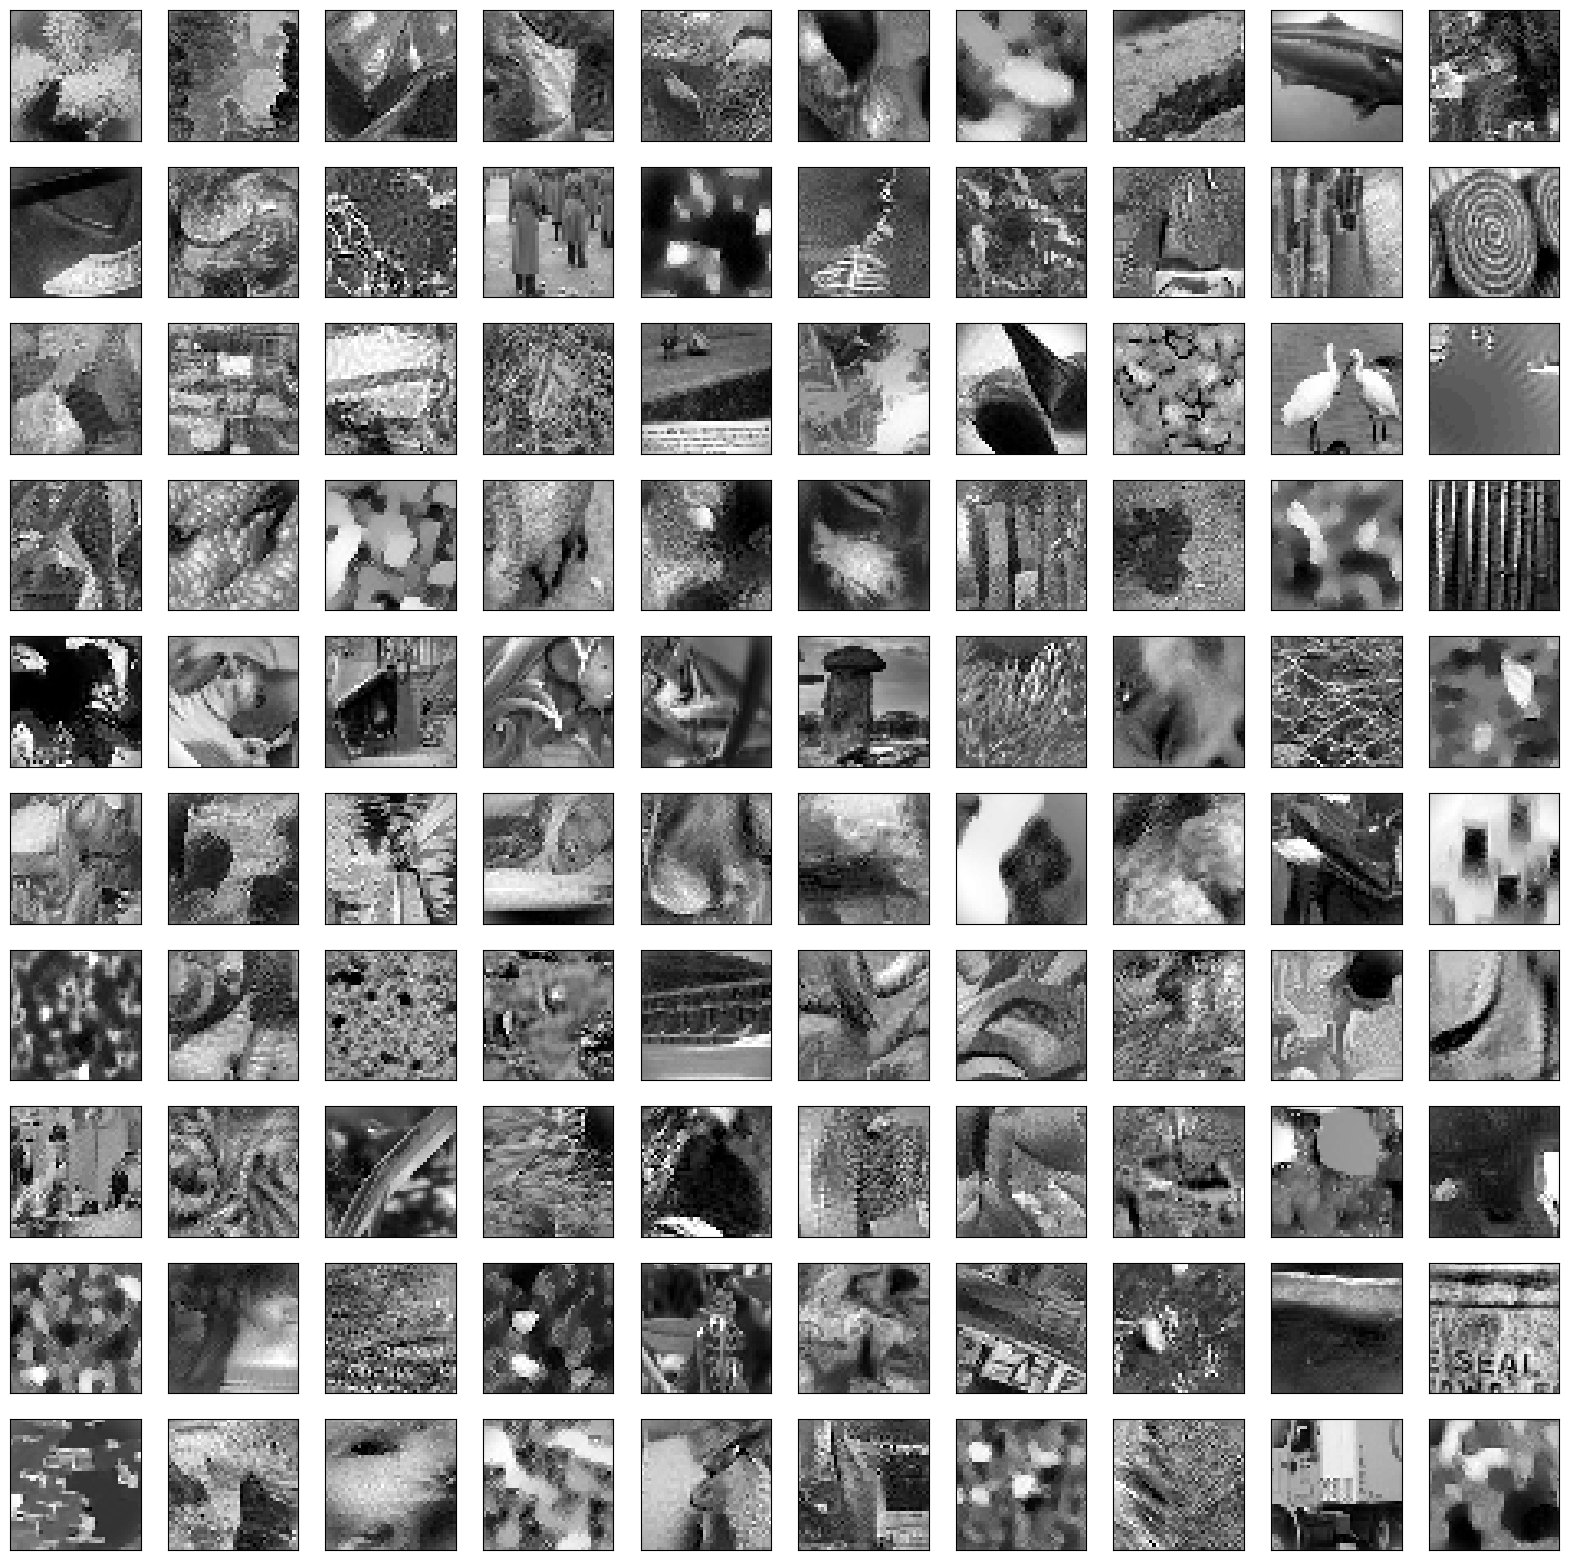

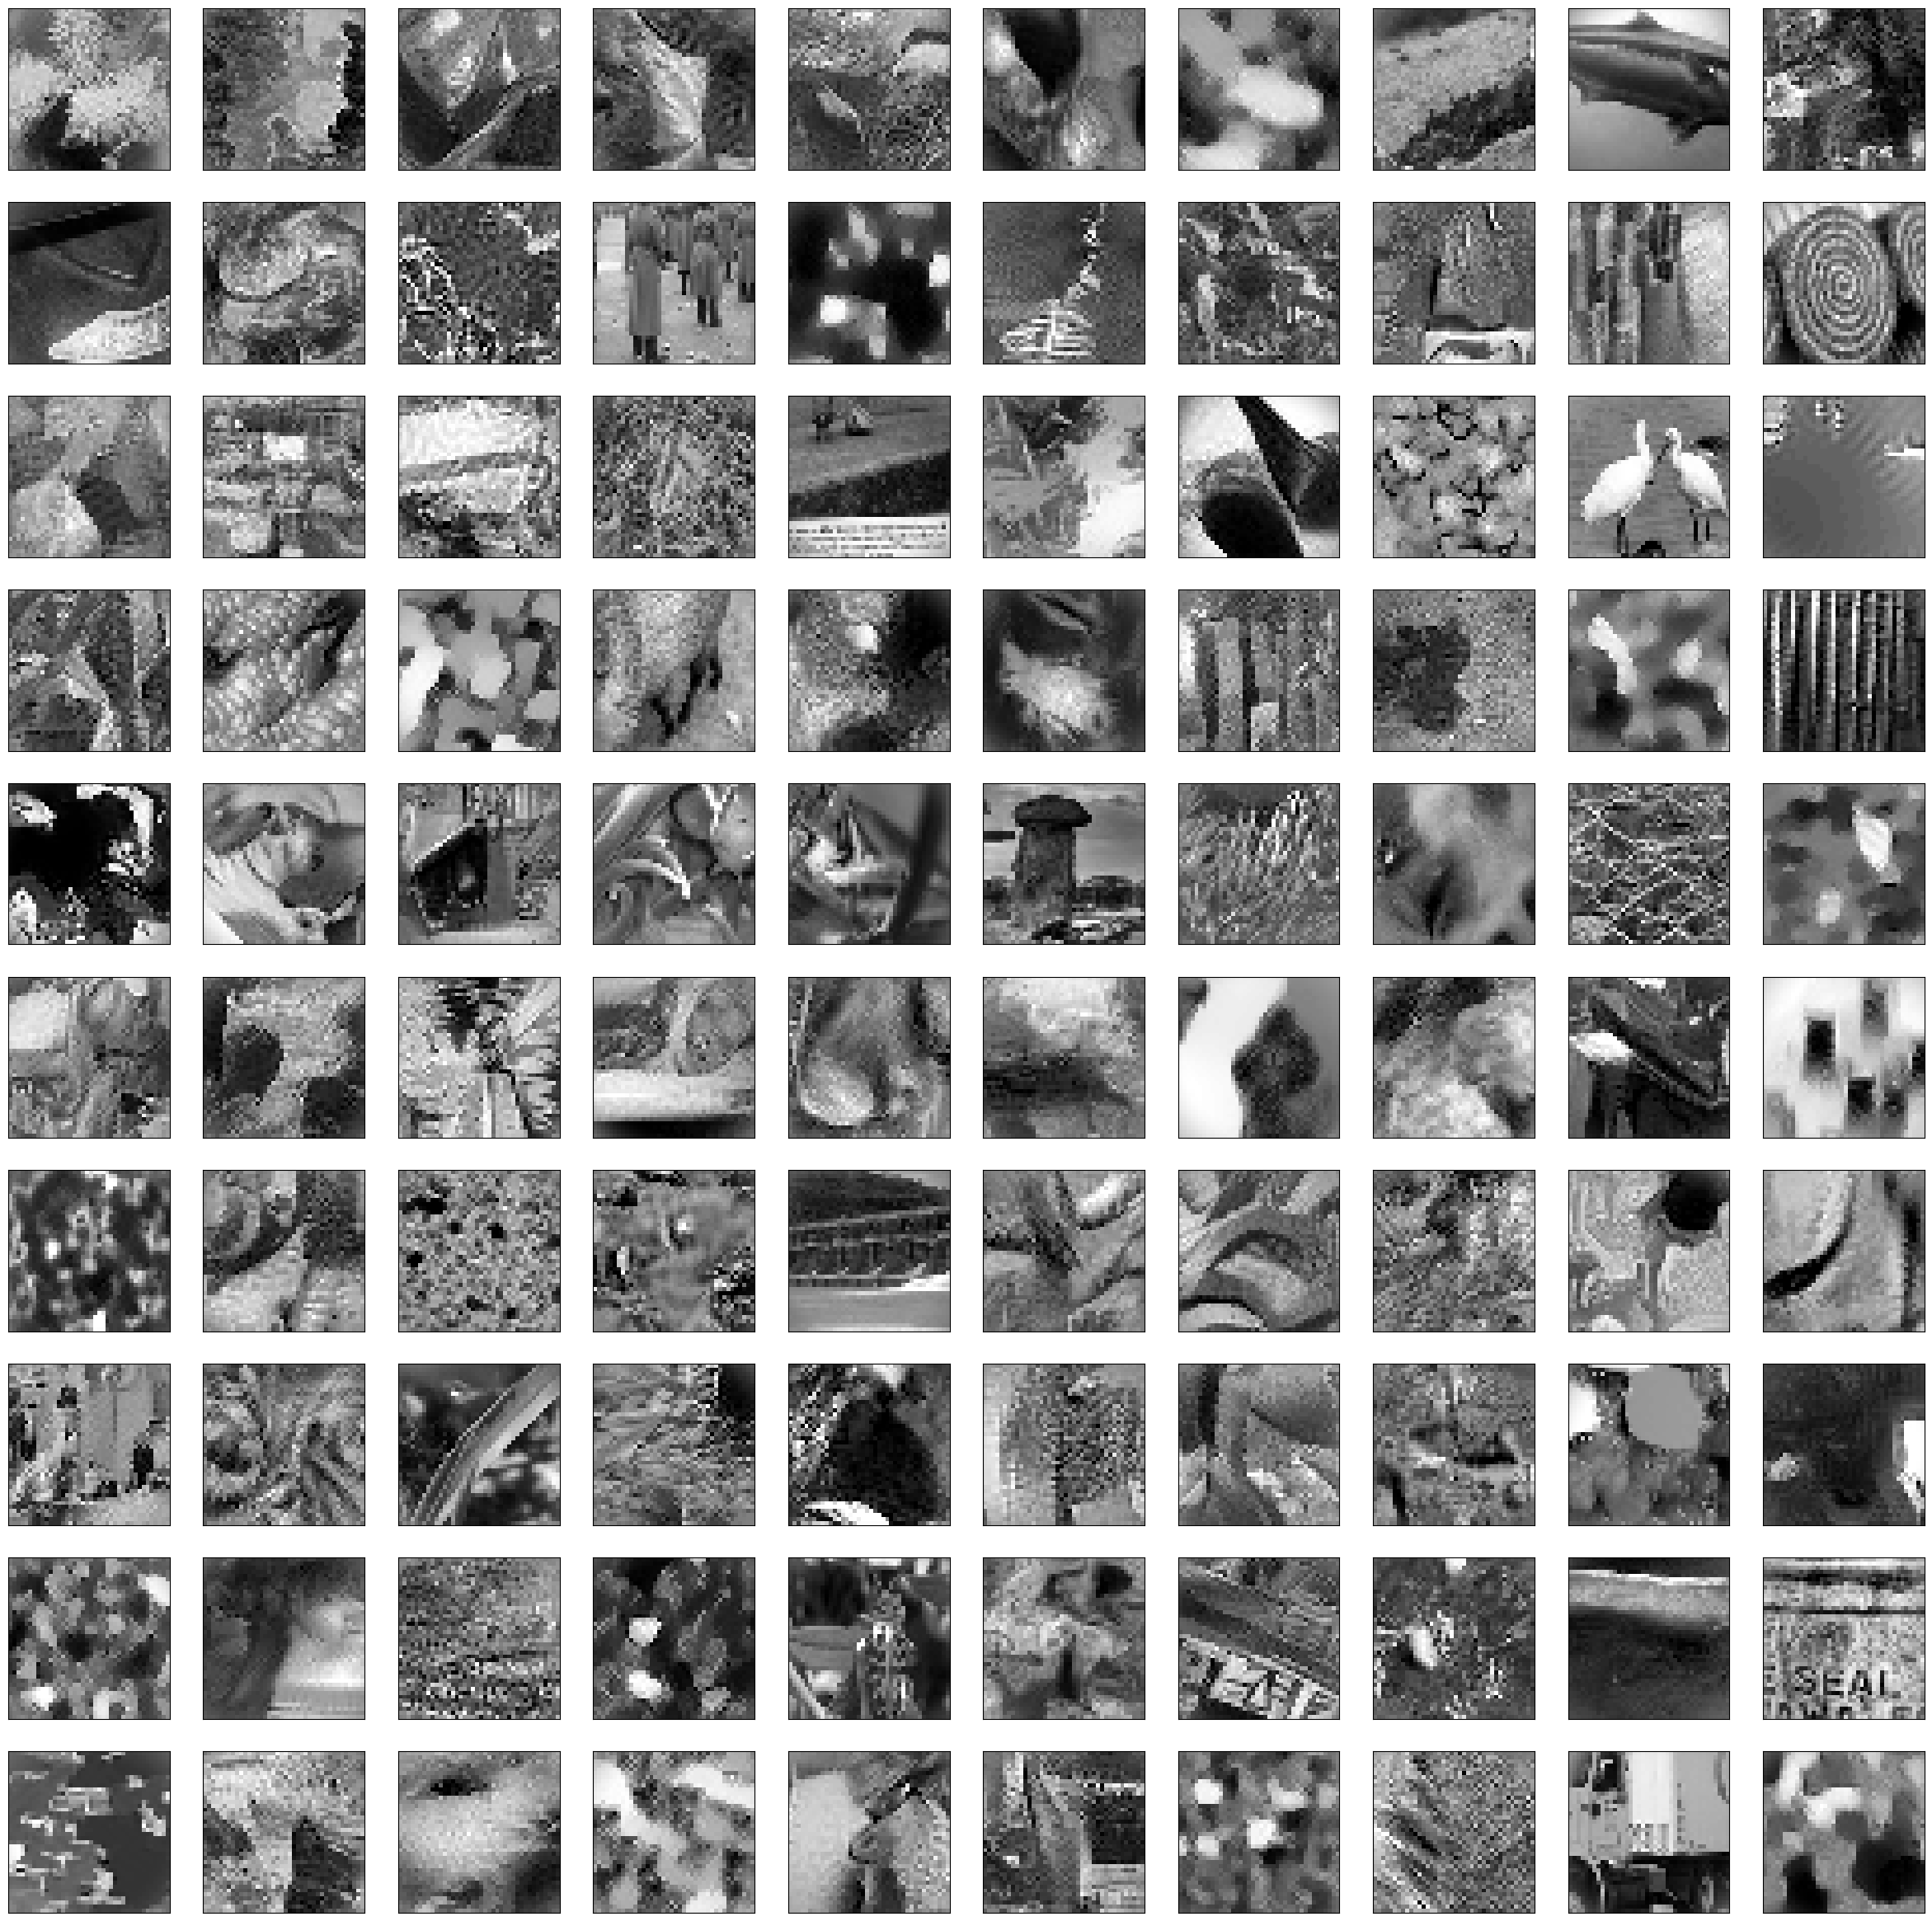

In [11]:
PLOT = True
BATCH_SIZE = 256
if(PLOT):
  rows = 10
  fig, axes = plt.subplots(nrows=rows, ncols=rows, sharex=True, figsize=(20, 20))
  img_batch, res_batch, real_batch = dataset.minibatch(BATCH_SIZE)
  print("img_batch", img_batch.shape)
  images = torch.tensor(img_batch).permute(0, 3, 1, 2)
  print("images", images.shape)
  print("squeezed", images[0].squeeze().shape)
  for p in range(rows * rows):
    axes[p//rows,p%rows].imshow(images[p].squeeze(), cmap="gray")
    axes[p//rows,p%rows].set_xticks([])
    axes[p//rows,p%rows].set_yticks([])

  fig, axes = plt.subplots(nrows=rows, ncols=rows, sharex=True, figsize=(30, 30))
  for p in range(rows * rows):
    axes[p//rows,p%rows].imshow(img_batch[p].squeeze(), cmap="gray")
    axes[p//rows,p%rows].set_xticks([])
    axes[p//rows,p%rows].set_yticks([])


In [12]:
from scipy import stats
from torchmetrics.regression import PearsonCorrCoef

def evaluate_corr_vals(pred, res, real_res):
  corrs = []
  for i in range(NUM_NEURONS):
    # keep only entries corresponding to real_res
    r = res[:, i]
    p = pred[:, i]
    b = real_res[:, i].astype(bool)
    r = np.compress(b, r)
    p = np.compress(b, p)
    corr = stats.pearsonr(r, p)[0]
    if np.isnan(corr):
        print("INFO: corr for neuron " + str(i) + " is nan - replaced by 0")
        corr = 0
    corrs.append(corr)

  return corrs

def evaluate_avg_corr_val(pred, res, real_res):
  """Prediction correlation averaged across neurons on validation set."""
  avg_corr = np.mean(evaluate_corr_vals(pred, res, real_res))
  return avg_corr

def evaluate_pearson_correl(pred, res, real_res):
  pearson = PearsonCorrCoef(num_outputs=pred.shape[1]).to(device)
  eff_res = res * real_res
  return torch.mean(pearson(pred, eff_res))

class CustomLoss(nn.Module):
  def __init__(self):
    super(CustomLoss, self).__init__()

  def forward(self, prediction, responses_pair):
    response, real_responses = responses_pair
    # Calculate the loss
    loss = torch.mean(
        torch.sum((prediction - response * torch.log(prediction + 1e-9)) * real_responses, dim=0)
        / torch.sum(real_responses, dim=0)
    )
    return loss

In [13]:
loss_list = []  # Store loss history

def train():
  data_dict = Dataset.get_clean_data()
  dataset = MonkeySubDataset(data_dict, seed=1000, train_frac=0.8, subsample=2, crop=30)

  smooth_weights = torch.tensor([log_uniform(low=-9, high=-3.5), 0, 0]).to(device)
  sparse_weights = [0.0, 0.00025, 0.00025]
  readout_sparse_weight = log_uniform(low=-5.5, high=-1)
  trainSize = dataset.train()
  print(trainSize[0].shape[0])

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  loss_func = nn.PoissonNLLLoss()
  num_neurons= 166 #int(QUBITS/2)

  # Start training
  epochs = EPOCHS  # Set number of epochs
  model.train()  # Set model to training mode

  log_interval = 10

  for epoch in range(epochs):
    total_loss = []

    not_improved = 0
    num_lr_updates = 0
    dataset.next_epoch()

    for p in range(500):
      if(BATCH_SIZE*(p+1) > trainSize[0].shape[0]):
        # for name, param in model.named_parameters():
        #   if param.requires_grad and "weight" in name:
        #     print(name, param.data.shape, param.data[0, 0, 0, :3].data)    
        imgs_val, res_val, real_resp_val = dataset.val()
        data_val = torch.Tensor(imgs_val)[:10].to(device)
        target_val = torch.Tensor(res_val)[:10].to(device)
        real_target_val = torch.Tensor(real_resp_val)[:10].to(device)
        target_val = target_val[:,NEURONS_FROM:NEURONS_FROM+QUBITS]
        real_target_val = real_target_val[:,NEURONS_FROM:NEURONS_FROM+QUBITS]
        output_val = model(data_val)
        loss = loss_func(output_val, target_val)
        # pearson = evaluate_pearson_correl(output_val, target_val, real_target_val)
        print(epoch, "step ", p, "Loss ", loss.item())
        break
      imgs_batch, res_batch, real_batch = dataset.minibatch(BATCH_SIZE)
      data = torch.Tensor(imgs_batch).to(device)
      target = torch.Tensor(res_batch).to(device)
      target = target[:,NEURONS_FROM:NEURONS_FROM+QUBITS]
      real_target = torch.Tensor(real_batch).to(device)
      output = model(data)
      # print(output[0].data, target[0].data)
      # print(p, "output", output.data)
      loss = loss_func(output, target)  # Calculate loss
      penalty1 = 0.0
      penalty2 = 0.0
      penalty3 = 0.0
      for name, param in model.named_parameters():
        if 'conv1.weight' in name:  # Assuming you want to regularize weights
          penalty1 = smoothness_regularizer_2d(torch.permute(param, (2, 3, 0, 1)), smooth_weights[0]) + group_sparsity_regularizer_2d(param, sparse_weights[0])
        # elif 'conv2.weight' in name:  # Assuming you want to regularize weights
        #   penalty2 = smoothness_regularizer_2d(torch.permute(param, (2, 3, 0, 1)), smooth_weights[1]) + group_sparsity_regularizer_2d(param, sparse_weights[1])
        # elif 'conv3.weight' in name:  # Assuming you want to regularize weights
        #   penalty3 = smoothness_regularizer_2d(torch.permute(param, (2, 3, 0, 1)), smooth_weights[2]) + group_sparsity_regularizer_2d(param, sparse_weights[2])
      # for name, param in model.named_parameters():
      #   if param.requires_grad and name == 'qnn.weight':
      #     print(name, param.data)      
      loss += penalty1 + penalty2 + penalty3
      print(epoch, p, "Loss ", loss.item(), "MSE", torch.mean((target - output) ** 2).item() # output.T[:, :5].data, target.T[:, :5].data, 
      )
      pearson = evaluate_pearson_correl(output, target, real_target[:,NEURONS_FROM:NEURONS_FROM+QUBITS])
      optimizer.zero_grad()  # Initialize gradient set_to_none=True
      loss.backward()  # Backward pass
      optimizer.step()  # Optimize weights
      total_loss.append(loss.item())  # Store loss
      loss_list.append(sum(total_loss) / len(total_loss))
    # print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

if(MODE == "Train"):
  train()

Subtracting mean: 112.51203
18560
0 0 Loss  2.0594265460968018 MSE 1.472292423248291


c:\QCNNModelForCanonicalComputation\.canonical\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


0 1 Loss  2.1229019165039062 MSE 1.198044776916504
0 2 Loss  2.118293523788452 MSE 1.2452369928359985
0 3 Loss  2.184065818786621 MSE 1.1704689264297485
0 4 Loss  2.117082357406616 MSE 1.1650892496109009
0 5 Loss  2.020585060119629 MSE 1.4984114170074463
0 6 Loss  2.025724172592163 MSE 1.2887581586837769
0 7 Loss  2.1234829425811768 MSE 1.2859693765640259
0 8 Loss  2.077880859375 MSE 1.2551509141921997
0 9 Loss  2.1723358631134033 MSE 1.241663932800293
0 10 Loss  2.247098922729492 MSE 1.1342275142669678
0 11 Loss  2.13744854927063 MSE 1.2234288454055786
0 12 Loss  2.048311710357666 MSE 1.222661018371582
0 13 Loss  2.1118147373199463 MSE 1.1913526058197021
0 14 Loss  2.2404754161834717 MSE 1.2326197624206543
0 15 Loss  2.0942368507385254 MSE 1.1490674018859863
0 16 Loss  2.0170252323150635 MSE 1.3382495641708374
0 17 Loss  2.055389165878296 MSE 1.31130051612854
0 18 Loss  2.072514057159424 MSE 1.2087481021881104


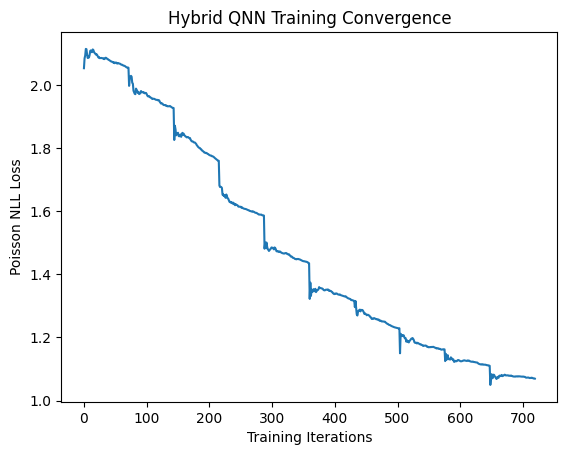

In [ ]:

if(MODE == "Train"):
  plt.plot(loss_list)
  plt.title("Hybrid QNN Training Convergence")
  plt.xlabel("Training Iterations")
  plt.ylabel("Poisson NLL Loss")
  plt.show()

In [ ]:
# Save the model
if(MODE == "Train"):
  torch.save(model.state_dict(), "qnn-model-gpu.pt")

In [ ]:
if(MODE == "Test"):
  model = Net().to(device)
  model.load_state_dict(torch.load("qnn-model-gpu.pt"))

In [ ]:
def nanarray(real_resps, resps):
  """Inserts nan at every position in resps where corresponding positions in real_resps are 0.
  Hence, leading to an array of resps where non-real responses have value nan.
  """

  return np.where(real_resps, resps, np.nan)
  
def calculateFEV1(predictions_test, responses_test, real_responses_test, nrep, nim, tneu, nneu, fneu):
  predictions_test = torch.tile(predictions_test, (4, 1)).detach().cpu().numpy()
  resps_test_nan = dataset.nanarray(real_responses_test, responses_test)
  resps_test = resps_test_nan.reshape([nrep * nim, tneu])
  sresps_test = resps_test[:,fneu:fneu+nneu]
  MSE = np.nanmean((predictions_test - sresps_test) ** 2, axis=0)
  obs_var_avg, total_variance, explainable_var = [], [], []
  for n in range(tneu):
    rep = dataset.repetitions[n]
    resp_ = resps_test_nan[:rep, :, n]
    v = np.nanvar(resp_, axis=0, ddof=1)
    obs_var = np.nanmean(v, axis=0)
    obs_var_avg.append(obs_var)
    tot_var = np.nanvar(resp_, axis=(0, 1), ddof=1)
    total_variance.append(tot_var)
    explainable_var.append(tot_var - obs_var)
  total_variance = np.array(total_variance)
  explainable_var = np.array(explainable_var)
  mean_var_explained = total_variance.mean() - MSE.mean()
  print("MSE", MSE.mean(), "total_variance", total_variance.mean(), "mean_var_explained", mean_var_explained, "explainable_var", explainable_var.mean(), "eve", (mean_var_explained * 100/ explainable_var).mean())
  return (mean_var_explained / explainable_var).mean()




In [ ]:
#Calculate Fraction of Explainable Variance
def calculateFEV2(predictions_test, responses_test, real_responses_test, 
  nrep, nim, tneu, nneu, fneu):
  predictions_test = torch.tile(predictions_test, (4, 1)).detach().cpu().numpy()
  resps_test_nan = dataset.nanarray(real_responses_test, responses_test)
  resps_test = resps_test_nan.reshape([nrep * nim, tneu])
  sresps_test = resps_test[:,fneu:fneu+nneu]
  MSE = np.nanmean((predictions_test - sresps_test) ** 2, axis=0)
  obs_var_avg, total_variance, explainable_var = [], [], []
  for n in range(tneu):
    rep = dataset.repetitions[n]
    resp_ = resps_test_nan[:rep, :, n]
    v = np.nanvar(resp_, axis=0, ddof=1)
    obs_var = np.nanmean(v, axis=0)
    obs_var_avg.append(obs_var)
    tot_var = np.nanvar(resp_, axis=(0, 1), ddof=1)
    total_variance.append(tot_var)
    explainable_var.append(tot_var - obs_var)
  total_variance = np.array(total_variance)
  explainable_var = np.array(explainable_var)
  mean_var_explained = total_variance.mean() - MSE.mean()
  print(
    "MSE", MSE.mean(), 
    "total_variance", total_variance.mean(), 
    "mean_var_explained", mean_var_explained, 
    "explainable_var", explainable_var.mean(), 
    "fev%", (mean_var_explained * 100 / explainable_var.mean()))
  return mean_var_explained / explainable_var.mean()

In [ ]:
# Evaluate, calculate FEV
images_test, responses_test, real_responses_test = dataset.test()
total_count = images_test.shape[0]
print("total_count", total_count)
iterations = total_count//BATCH_SIZE +1
nrep, nim, tneu = responses_test.shape
nneu = QUBITS
fneu = NEURONS_FROM

predictions = torch.zeros(1, 166)

for i in range(iterations):
  data = torch.Tensor(images_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE]).to(device)
  predictions_test = model(data)
  if i == 0:
    predictions = predictions_test
  else:
    predictions = torch.cat((predictions, predictions_test))
fev = calculateFEV2(predictions, responses_test, real_responses_test, nrep, nim, tneu, nneu, fneu)
print("FEV", fev, "%")

total_count 1450
MSE 1.7312603 total_variance 2.577825 mean_var_explained 0.84656477 explainable_var 0.9259978 fev% 91.42189922349638
FEV 0.914219 %


/tmp/ipykernel_17219/3525559519.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v = np.nanvar(resp_, axis=0, ddof=1)
